## TODO:
- Need to be able to handle frame that take longer than expected to come in

In [1]:
import time
import cv2
import numpy as np
import logging
from multiprocessing_logging import install_mp_handler
import ctypes
import matplotlib.pyplot as plt

import threading as t
import multiprocessing as mp
import queue as q

from modules.FrameServer import FrameServer

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s',
                    filename='log/sonicam.log',
                    filemode='w')

install_mp_handler()

# info = mp.get_logger().info
# logger = mp.log_to_stderr()
# logger.setLevel(logging.INFO)

In [ ]:
video_driver = FrameServer()
queue = video_driver.get_job_queue()
conn_recv,conn_send = mp.Pipe(duplex=False)
time.sleep(0.5)
start = time.time()
shapes = ((int(1080/2),int(1920/2)),(int(1080/3),int(1920/3)),(int(1080/4),int(1920/4)),(int(1080/5),int(1920/5)))
job = {"type":"scale","shapes":shapes,"time":None,"pipe":conn_send}
queue.put(job)
sending_time = []
results = []
for _ in range(len(shapes)):
    results.append(conn_recv.recv())
    sending_time.append(time.time()-results[-1]["send_time"])
print(time.time()-start)
print(sending_time)
video_driver.kill()

None


Process CameraWorker:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/meskupie/fydp/sonicam/sonicam/modules/FrameServer.py", line 63, in run
    self.spin_frame_capture()
  File "/home/meskupie/fydp/sonicam/sonicam/modules/FrameServer.py", line 50, in spin_frame_capture
    shared_vars["buffer_frames"][buffer_index][1][:] = np.copy(frame)
TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'


In [5]:
results

[{'frame': array([[[171, 159, 156],
          [240, 229, 223],
          [228, 219, 211],
          ...,
          [104,  97, 102],
          [107, 100, 105],
          [109, 102, 107]],
  
         [[102,  85,  98],
          [136, 121, 129],
          [139, 127, 133],
          ...,
          [104,  97, 102],
          [107, 100, 105],
          [111, 104, 109]],
  
         [[ 79,  48, 110],
          [ 79,  50, 104],
          [ 79,  54, 100],
          ...,
          [105,  97, 104],
          [108, 100, 107],
          [110, 102, 109]],
  
         ...,
  
         [[ 27,  38,  68],
          [ 27,  35,  70],
          [ 31,  35,  77],
          ...,
          [  1,   1,   1],
          [  1,   1,   1],
          [  1,   1,   1]],
  
         [[ 26,  37,  66],
          [ 25,  34,  67],
          [ 25,  30,  67],
          ...,
          [  1,   1,   1],
          [  1,   1,   1],
          [  1,   1,   1]],
  
         [[ 43,  55,  83],
          [ 43,  53,  83],
          [ 41,

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


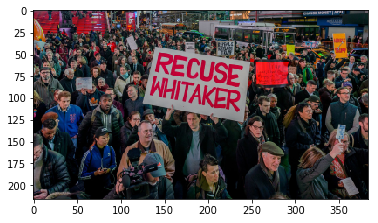

In [10]:
plt.imshow(cv2.cvtColor(results[3]["frame"], cv2.COLOR_BGR2RGB))

## Mem copy profileing

In [13]:
import numpy as np
import cv2

file = "data/sample.jpg"
frame = cv2.imread(file)
def profile(frame):
    test = np.copy(frame)
    return test

%timeit profile(frame)


1.01 ms ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# FrameServer Reference

In [ ]:
# Global Variables
param_n_image_workers = 5
param_image_buffer_length = 10
param_image_buffer_end = 2

param_frame_shape = (1080,1920,3)
param_frame_period = 0.1

shared_vars = {}

# ===================================
# 
# ===================================
class CameraDriverWorker(mp.Process):
    # Barebones initialization, pass shared data structures into the process and start it
    def __init__(self,name_,run_event_,main_queue_,buffer_frames_,buffer_times_,buffer_index_):
        super(CameraDriverWorker, self).__init__()
        self.name = name_
        self.run_event = run_event_
        self.main_queue = main_queue_
        global shared_vars
        shared_vars["buffer_frames"] = buffer_frames_
        shared_vars["buffer_times"] = buffer_times_
        shared_vars["buffer_index"] = buffer_index_
        self.start()
    
    def spin_frame_capture(self):
        file = "data/sample.jpg"
        frame = cv2.imread(file)
        while self.run_event.is_set():
            start = time.time()
            with shared_vars["buffer_index"].get_lock():
                shared_vars["buffer_index"].value = (int(shared_vars["buffer_index"].value)+1) \
                    %param_image_buffer_length
                buffer_index = int(shared_vars["buffer_index"].value)
                with shared_vars["buffer_frames"][buffer_index][0].get_lock():
                    # Dump image data into buffer
                    shared_vars["buffer_frames"][buffer_index][1][:] = np.copy(frame)
                    with shared_vars["buffer_times"][0].get_lock():
                        shared_vars["buffer_times"][1][buffer_index] = time.time()
            # Add response to queue
            self.main_queue.put({"type":"camera","index":buffer_index})
            # Delay to achieve ~40Hz
            global param_frame_period
            delay = param_frame_period-(time.time()-start)
            #logging.debug("Roll: "+str(buffer_index)+", "+str(delay))
            time.sleep(max(0,delay))
    
    def run(self):
        logging.debug("Driver Process Started")
        self.spin_frame_capture()

# ===================================
# 
# ===================================
class ImageProcessingWorker(mp.Process):
    # Barebones initialization, pass shared data structures into the process and start it
    def __init__(self,name_,run_event_,main_queue_,job_queue_,send_lock_, \
        buffer_frames_,buffer_times_,buffer_index_):
        super(ImageProcessingWorker, self).__init__()
        self.name = name_
        self.run_event = run_event_
        self.main_queue = main_queue_
        self.job_queue = job_queue_
        self.send_lock = send_lock_
        global shared_vars
        shared_vars["buffer_frames"] = buffer_frames_
        shared_vars["buffer_times"] = buffer_times_
        shared_vars["buffer_index"] = buffer_index_
        self.start()
        
    def send_acknowledgement(self,index):
        job = {"type":"acknowledge","location":"processing","index":index}
        self.main_queue.put(job)
    
    def send_error(self,message):
        job = {"type":"error","message":message}
        self.main_queue.put(job)
        
    def service_jobs(self):
        while self.run_event.is_set():
            job = self.job_queue.get()
            
            # {"type":"scale","shape":(h,w),"buffer_index":int,"pipe":connector}
            if job["type"] == "scale":
                h,w = job["shape"]
                new_frame = cv2.resize(shared_vars["buffer_frames"][job["buffer_index"]][1],(w,h), \
                    interpolation = cv2.INTER_AREA)
                resp = {"type":"scale","frame":new_frame,"shape":(h,w), \
                    "time":shared_vars["buffer_times"][1][job["buffer_index"]]}
                with self.send_lock:
                    resp["send_time"] = time.time()
                    job["pipe"].send(resp)
                self.send_acknowledgement(job["buffer_index"])
            
            # {"type":"crop","loctions":(((x0,y0),(x1,y1)),),shape":(h,w),
            # "buffer_index":int,"pipe":connector}
            elif job["type"] == "crop":
                pass
            
            elif job["type"] == "kill": # The message to kill the thread
                self.job_queue.put({"type":"kill"}) # Replaced used kill job
                logging.debug("Worker Killed")
                break
                
            else:
                send_error("Unknown job in image processor")
                
    
    def run(self):
        logging.debug("Worker Process Started")
        self.service_jobs()

# ===================================
# 
# ===================================
class VideoDriverProcess(mp.Process):
    # Barebones initialization, pass shared data structures into the process and start it
    def __init__(self,name_,job_queue_,buffer_frames_,buffer_times_,buffer_index_):
        super(VideoDriverProcess, self).__init__()
        self.name = name_
        # Grab references to linking data
        self.job_queue = job_queue_
        global shared_vars
        shared_vars["buffer_frames"] = buffer_frames_
        shared_vars["buffer_times"] = buffer_times_
        shared_vars["buffer_index"] = buffer_index_
        
        # Start the Process
        self.start()
    
    # Initialize all objects that are used in the video driver
    def init_objects(self):
        # Event to signal stopping of all threads
        self.run_event = mp.Event()
        self.run_event.set()
        
        # Initialize buffer index so that the first frame goes in index 0
        self.local_buffer_index = param_image_buffer_length-1
        with shared_vars["buffer_index"].get_lock():
            shared_vars["buffer_index"].value = self.local_buffer_index
        
        # Objects for processing pool jobs
        self.image_job_queue = mp.Queue()
        self.image_processing_send_lock = mp.Lock()
        self.buffer_index_count = np.zeros(param_image_buffer_length)
        self.buffer_index_times = np.zeros(param_image_buffer_length)
#         with shared_vars["frame_time"].get_lock():
#             self.image_grabbed_current = shared_vars["frame_time"].value

        # State Variables
        self.is_rolling = False
    
    # Startup all processes and threads that run in the background
    def start_processes(self):
        # Create Workers
        self.image_processing_workers = []
        for i in range(param_n_image_workers):
            name = "ImageWorker-"+str(i)+"of"+str(param_n_image_workers)
            worker = ImageProcessingWorker(name,self.run_event,self.job_queue,self.image_job_queue, \
                self.image_processing_send_lock,shared_vars["buffer_frames"],shared_vars["buffer_times"], \
                shared_vars["buffer_index"])
            self.image_processing_workers.append(worker)
        
        # Create Camera Driver
        name = "CameraWorker"
        self.camera_driver_worker = CameraDriverWorker(name,self.run_event,self.job_queue, \
            shared_vars["buffer_frames"],shared_vars["buffer_times"],shared_vars["buffer_index"])
    
    # Analyse the buffer index and the delta time between frames to verify that no frames were skipped
    # and that the current frame buffer is consistent.
    def update_buffer_index(self,index):
        with shared_vars["buffer_index"].get_lock():
            prev_buffer_index = self.local_buffer_index # temp storage
            # update the local frame buffer index
            self.local_buffer_index = (self.local_buffer_index+1)%param_image_buffer_length
            if self.is_rolling:
                # Check if the index increment is consistent and we didnt skip frames
                if (index != self.local_buffer_index) or (shared_vars["buffer_index"].value != index):
                    logging.error("Frame de-sync (index) in camera driver")
                # Check the time delta between frames to make sure we are not dropping frames
                with shared_vars["buffer_times"][0].get_lock():
                    dt = shared_vars["buffer_times"][1][self.local_buffer_index] - \
                        shared_vars["buffer_times"][1][prev_buffer_index]
                    if dt > param_frame_period*1.5:
                        logging.error("Frame de-sync (time) in camera driver: "+str(dt))
    
    # Using the lookup_time, find the coresponding buffer index to provide. Lock this index acording to
    # the number of locks requested. If the coresponding time is farther back than what is available
    # in the first n-m buffer indexs (leaving the last m indexs available for new frames) 
    def get_buffer_index(self,lookup_time,lock_count=1):
        with shared_vars["buffer_times"][0].get_lock():
            if lookup_time != None:
                found_index = (np.abs(shared_vars["buffer_times"][1]-lookup_time)).argmin()
                #dt = shared_vars["buffer_times"][1][found_index]-lookup_time
                # Check if the found index is too close to the end of the buffer
                delta_index = (self.local_buffer_index-found_index)%param_image_buffer_length
                if (delta_index <= param_image_buffer_end) and (delta_index != 0):
                    return -1
            else:
                found_index = self.local_buffer_index
            # If this index isn't being used, grab a lock to the frame array
            if self.buffer_index_count[found_index] == 0:
                shared_vars["buffer_frames"][found_index][0].acquire()
                self.buffer_index_times[found_index] = time.time()
        # Add to a count of this index being used
        self.buffer_index_count[found_index] += lock_count
        return found_index
    
    # Decrease the count of a used buffer index, when the count reaches 0, free the lock.
    # Determine the length of time that the buffer index was held for to ensure that there is enough
    # end frame buffer available to be filled while indexs are locked
    def free_buffer_index(self,index,unlock_count=1):
        self.buffer_index_count[index] -= unlock_count
        if self.buffer_index_count[index] == 0:
            # Find the lock durration and log if it is longer than the available space on the frame buffer
            dt = time.time()-self.buffer_index_times[index]
            logging.info("Last job took: "+str(dt)+" seconds")
            if dt >= param_image_buffer_end*param_frame_period:
                logging.error("Locked frame for longer than available buffer space: "+str(dt))
            shared_vars["buffer_frames"][index][0].release()
        elif self.buffer_index_count[index] < 0:
            logging.error("Unlocked too many counts to frame buffer")
        
    # Read incomming jobs in the job_queue and service them based on "type"
    def service_jobs(self):
        while True:
            job = self.job_queue.get()
            try:
                # Service jobs that are allowed before we are rolling 
                if job["type"] == "kill":
                    logging.debug("Killing Main")
                    self.kill()
                    break
                elif job["type"] == "camera":
                    self.update_buffer_index(job["index"])
                    self.is_rolling = True # We have recieved at least one frame
                elif job["type"] == "error":
                    logging.error(job["message"])

                # Service jobs after we are rolling, else put jobs back
                elif self.is_rolling:
                    
                    #{"type":"scale","shapes":((h,w),),"time":(None/time.time()),"pipe":connector}
                    if job["type"] == "scale":
                        # try / except in case there is no "time" key
                        try: time = job["time"]
                        except KeyError: time = None
                        index = self.get_buffer_index(time,len(job["shapes"]))
                        if index == -1:
                            job["pipe"].send({"type":"error","message":"Not enough history in the buffer"})
                        else:
                            for shape in job["shapes"]:
                                image_job = {"type":"scale","shape":shape,"buffer_index":index, \
                                    "pipe":job["pipe"]}
                                self.image_job_queue.put(image_job)
                    
                    #{"type":"crop","loctions":(((x0,y0),(x1,y1)),),"shape":(h,w), \
                    #"time":(None/time.time()),"pipe":connector}
                    elif job["type"] == "crop":
                        # try / except in case there is no "time" key
                        try: time = job["time"]
                        except KeyError: time = None
                        index = self.get_buffer_index(time,len(job["locations"]))
                        if index == -1:
                            job["pipe"].send({"type":"error","message":"Not enough history in the buffer"})
                        else:
                            for location in job["locations"]:
                                image_job = {"type":"crop","location":location,"shape":job["shape"], \
                                    "buffer_index":index,"pipe":job["pipe"]}
                                self.image_job_queue.put(image_job)
                    
                    elif job["type"] == "acknowledge":
                        if job["location"] == "processing":
                            self.free_buffer_index(job["index"])
                    
                    else:
                        logging.error("Unknown job type")
                else:
                    # Put the job back in the queue untill we start rolling frames
                    self.job_queue.put(job)
            except KeyError as e:
                logging.error("Could not service video driver job with tag: "+str(e))
    
    # Kill off all worker processes and wait until they are all dead
    def kill_pool_workers(self):
        self.image_job_queue.put({"type":"kill"})
        for worker in self.image_processing_workers:
            worker.join() # wait till they are all done executing
    
    # Kill all child processes and wait until they are all dead
    def kill(self):
        self.run_event.clear()
        self.kill_pool_workers()
        logging.debug("Workers Killed")
        self.camera_driver_worker.join()
        
    # This function is called when the main process is started "self.start()"
    def run(self):
        # Initialize all objects
        self.init_objects()
        # Create workers to run in the background
        self.start_processes()
        # Main loop to service and distribute jobs
        self.service_jobs()

# ===================================
# 
# ===================================
class VideoDriver:
    def __init__(self):
        self.job_queue = mp.Queue()
        # Create the frame buffer out of n shared arrays
        raw_frame_arrays = [mp.Array(ctypes.c_ubyte,int(np.prod(param_frame_shape))) \
            for _ in range(param_image_buffer_length)]
        # Build tuples to store np arrays pointing to the shared memory
        self.buffer_images = [(array,np.frombuffer(array.get_obj(),dtype=np.uint8) \
            .reshape(param_frame_shape)) for array in raw_frame_arrays]
        # Create an array of times with coresponding np array handle
        raw_time_array = mp.Array(ctypes.c_double,param_image_buffer_length)
        self.buffer_times = (raw_time_array,np.frombuffer(raw_time_array.get_obj(),dtype=np.double))
        self.local_buffer_index = mp.Value(ctypes.c_ubyte)
        self.start()
    
    def start(self):
        # Define shared memory for VideoDriverProcess
        name = "FrameServer"
        self.main_process = VideoDriverProcess(name,self.job_queue, \
            self.buffer_images,self.buffer_times,self.local_buffer_index)
    
    def get_job_queue(self):
        return self.job_queue
    
    def kill(self):
        self.job_queue.put({"type":"kill"})
        self.main_process.join()